In [1]:
import copy
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from torchvision import transforms, datasets
import torch
from torch import nn

In [2]:
# Training code source: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [3]:
data_dir = "./data/"
model_name = "vgg" # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 2
batch_size = 32
input_size = 48
num_epochs = 100

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and transformsvalidation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
            
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 3 x 48 x 48 input
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=0),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(16 * 4 * 4, 128),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Linear(128, 2))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1, 16 * 4 * 4)
        out = self.layer4(out)
        out = self.layer5(out)
        
        return out

In [5]:
model_ft = CNN()

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [7]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

	 layer1.0.weight
	 layer1.0.bias
	 layer2.0.weight
	 layer2.0.bias
	 layer3.0.weight
	 layer3.0.bias
	 layer4.0.weight
	 layer4.0.bias
	 layer5.0.weight
	 layer5.0.bias


In [8]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
torch.save(model_ft, 'models/cow_classifer.pt')

Epoch 0/99
----------
train Loss: 0.7077 Acc: 0.4172
val Loss: 0.6963 Acc: 0.3708

Epoch 1/99
----------
train Loss: 0.6892 Acc: 0.5598
val Loss: 0.6808 Acc: 0.6231

Epoch 2/99
----------
train Loss: 0.6826 Acc: 0.5839
val Loss: 0.6728 Acc: 0.6231

Epoch 3/99
----------
train Loss: 0.6791 Acc: 0.5839
val Loss: 0.6683 Acc: 0.6231

Epoch 4/99
----------
train Loss: 0.6759 Acc: 0.5839
val Loss: 0.6635 Acc: 0.6231

Epoch 5/99
----------
train Loss: 0.6712 Acc: 0.5839
val Loss: 0.6561 Acc: 0.6231

Epoch 6/99
----------
train Loss: 0.6623 Acc: 0.5839
val Loss: 0.6427 Acc: 0.6231

Epoch 7/99
----------
train Loss: 0.6449 Acc: 0.5839
val Loss: 0.6154 Acc: 0.6231

Epoch 8/99
----------
train Loss: 0.6157 Acc: 0.5817
val Loss: 0.5767 Acc: 0.6170

Epoch 9/99
----------
train Loss: 0.5882 Acc: 0.6064
val Loss: 0.5472 Acc: 0.6413

Epoch 10/99
----------
train Loss: 0.5754 Acc: 0.6305
val Loss: 0.5358 Acc: 0.6869

Epoch 11/99
----------
train Loss: 0.5711 Acc: 0.6475
val Loss: 0.5274 Acc: 0.6900

Ep

train Loss: 0.1498 Acc: 0.9380
val Loss: 0.2051 Acc: 0.9240

Epoch 99/99
----------
train Loss: 0.1358 Acc: 0.9474
val Loss: 0.2139 Acc: 0.9331

Training complete in 0m 41s
Best val Acc: 0.933131


/home/ejmejm/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


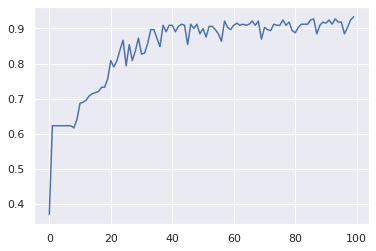

In [9]:
plt.plot(range(len(hist)), hist)